# Natural language processing on the OTIM-DB
This notebook present natural language processing (NLP) technique for information extraction from full-text research papers. The publications used are referenced by the [OTIM-DB](https://github.com/climasoma/otim-db).

NOTE: this notebook needs the full-text papers to run. For copyright reasons, these are not provided with the notebooks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import time
import os
import shutil
import re
from tqdm.notebook import tqdm_notebook as tqdm
from lxml import etree, html
import requests
import requests_cache
import spacy
from spacy.matcher import Matcher, PhraseMatcher
from spacy import displacy
import json
from pprint import pprint
import networkx as nx # drawing network graph
import unicodedata
from io import StringIO
from scipy import stats
nlp = spacy.load("en_core_web_sm")
import warnings
warnings.simplefilter('ignore')

datadir = '../data/from-kunsat/'
outputdir = datadir + '../../figures/'

dfscore = pd.DataFrame(columns={'step', 'n', 'recall', 'precision', 'f1', 'match'})

def camelCase(x):
    return x.lower()[0] + x.title().replace(' ','')[1:]

## Preparing publications
### Load paper list

In [2]:
# some statistics (start here)
dfpub = pd.read_excel(datadir + 'dfpub.xlsx')
print('total entries:', dfpub.shape[0])
print('with doi:', dfpub['DOI'].notnull().sum())
print('retrieved:', dfpub['fname'].notnull().sum())

# we will only work with the ones which have full-text
dfpub = dfpub[dfpub['fname'].notnull()].reset_index(drop=True)

total entries: 174
with doi: 156
retrieved: 154


In [3]:
# creating rawdocs and extract text
rawdocs = []
c = 0
for fname in dfpub['fname']:
    # convert to text (only need to do it once)
    #os.system('pdftotext "' + datadir + 'papers/' + fname + '.pdf"')
    fpath = datadir + 'papers/' + fname + '.txt'
    if os.path.exists(fpath):
        with open(fpath, 'r', encoding='utf8') as f:
            try:
                text = f.read()
                if len(text) > 100:
                    rawdocs.append(text)
                else:
                    print('document too small', fname)
                c += 1
            except:
                print('error with', fname)
                rawdocs.append('')
    else:
        print('path not found for', fname, fpath) # pdf are empty
        rawdocs.append('')
print('imported:', c, '/', dfpub.shape[0])

imported: 154 / 154


### Detecting abstract, references sections

Abstract is detected based on rules (specific keywords identfied, paragraph identified). The references section is also identified. Both abstract and references are removed from the main document, `rawdocs` is overwritten.

In [4]:
# detect abstract, keywords, reference, title - overwrite rawdocs!
abstracts = []
rawdocs = []
df = pd.DataFrame(columns=['fname', 'start', 'end', 'length', 'code'])
dfpub['abstract'] = pd.NA
for i, fname in enumerate(dfpub.loc[:, 'fname']):
    fpath = datadir + 'papers/' + str(fname) + '.txt'
    code = ''  # determine how the abstract was found
    if (pd.isna(fname) is False) & (os.path.exists(fpath)):
        with open(fpath, 'r', encoding='utf8') as f:
            doc = f.read()
        splitdoc = re.split('a b s t r a c t|abstract|ABSTRACT|Abstract|A B S T R A C T|Summary|s u m m a r y|SUMMARY', doc)
        foundStart = True
        if len(splitdoc) == 1:
            foundStart = False
        text = '\n'.join(splitdoc[1:]) if len(splitdoc) > 1 else splitdoc[0] # if not keyword abstract found, take all

        # assuming first paragraph is the abstract
        splitEnd = re.split('Published|Introduction|Copyright|©|Keywords|keywords|KEYWORDS|KEY WORDS|Citation', text)
        foundEnd = True
        if len(splitEnd) == 1:
            foundEnd = False
            #print('abstract end not found', fname)
            paragraphs = text.split('\n\n')
            ps = []
            a = ''
            # we only want paragraphs split that are more than 10 characters
            for p in paragraphs:
                a = a + '\n\n' + p
                if len(a) > 10:
                    ps.append(a)
                    a = ''
            if foundStart is True:
                abstract = ps[0]
                code = 'ps[0]'
            else:
                # without detection of the start or end, we
                # blindly assume that abstract is first paragraph
                abstract = ps[1]
                code = 'first'
                print('abstract = first paragraph', fname)
        else:
            abstract = ''
            for j, s in enumerate(splitEnd):
                if len(s) > 50 and abstract == '':
                    abstract = s
                    code = 's{:d}'.format(j)

        # cleaning up the abstract
        if abstract[0] in [':', '.']:
            abstract = abstract[1:]
        abstract = abstract.strip()

        # edge case (if we have two first large paragraphs)
        ts = abstract.split('\n\n')
        if len(ts) > 1:
            if (len(ts[0]) > 800) & (len(ts[1]) > 800):
                if ts[0][0] in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ':
                    abstract = ts[0]
                    #print(fname, 'first')
                    code = 'ts[0]'
                else:
                    abstract = ts[1]
                    #print(fname, 'second')
                    code = 'ts[1]'

        # write down abstract for manual assessment
        with open(fpath.replace('.txt', '-abstract.txt'), 'w', encoding='utf8') as f:
            f.write(abstract)
        df = df.append({'fname': fname, 'start': foundStart, 'end': 
                        foundEnd, 'length': len(abstract), 'code': code},
                       ignore_index=True)

        # add the abstract to dfpub
        dfpub.loc[i, 'abstract'] = abstract

        # remove the abstract from the body
        body = text.replace(abstract, '')

        # remove the references
        #if len(re.findall('r(é|e)f(é|e)rences?|r ?e ?f ?e ?r ?e ?n ?c ?e ?s?', body, flags=re.IGNORECASE)) == 0:
        #    print('no ref found for', fname)
        parts = re.split('\n\s?r(é|e)f(é|e)rences?\n|\n\s?r ?e ?f ?e ?r ?e ?n ?c ?e ?s?\n', body, flags=re.IGNORECASE)
        if len(parts) > 2:  # at least one 'reference' found
            body = '\nReferences\n'.join([a for a in parts[:-1] if a is not None])
        else:
            body = body
            #print('ref not found for', dfpub.loc[i, 'fname'])
            # for old papers with no ref section parsed to OCR, that's often the case
        # failsafe for badly detected abstract
        ratio = len(body) / len(text)
        if ratio < 0.6:
            print('abstract probably not well detected for', fname, '(ratio: {:.2f})'.format(ratio))
            body = text
        rawdocs.append(body)
    else:
        print(fpath, 'not found')
print('number of abstract detected:', dfpub['abstract'].notnull().sum(), '/', dfpub.shape[0])

abstract probably not well detected for jacques2002 (ratio: 0.47)
abstract = first paragraph miller1998
abstract probably not well detected for schwartz2002 (ratio: 0.12)
abstract probably not well detected for schwärzel2011 (ratio: 0.23)
number of abstract detected: 154 / 154


## Rule-based extraction

This section uses regular expression (RegEx) to extract information from documents. The recovered values are checked against a manually built database to evaluate their status.

Available status:
- If in the db:
    - 1. `Not parsed`: we didn't recover anything from NLP
    - 2. `Not matched`: we recover smth but it did not matched
    - 3. `Matched`: we recover smth and it matches
- If not in the db:
    - 4. `Unavailable`: the info is not in Bonares and we recovered nothing
    - 5. `Parsed`: we recover smth but we cannot compared it as Bonares entry is emtpy
    
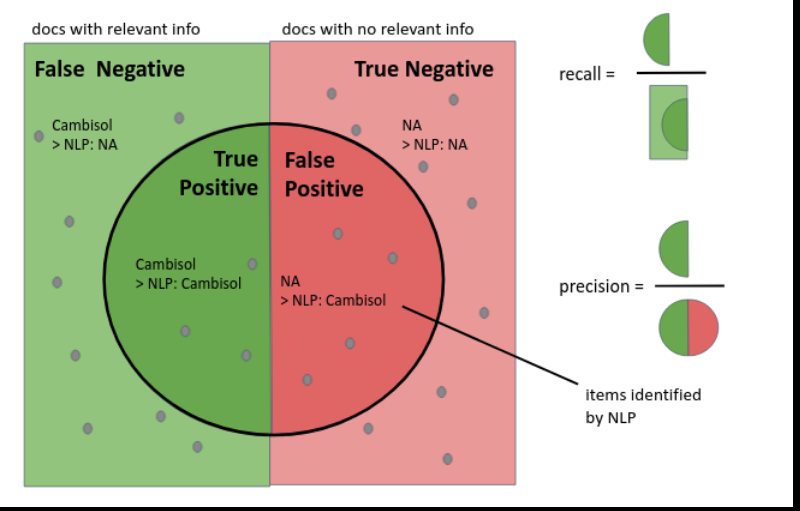

In [5]:
# prepare dfssp which contains soil site property
dfssp = pd.read_excel(datadir + 'dfssp.xlsx')
dfexp = pd.read_excel(datadir + 'dfexp.xlsx')
dfssp = pd.merge(dfssp, dfexp, on='SSPName', how='left')
# soil_type and soil_texture are manually created to reflect what is really written in the text

In [6]:
# prepare dfloc which contains the manually parsed location and precipitation
dfloc = pd.read_excel(datadir + 'dfloc.xlsx', na_values=-9999)
dfexp = pd.read_excel(datadir + 'dfexp.xlsx')
dfexp = dfexp[['Location', 'ReferenceTag']].drop_duplicates()
dfloc = pd.merge(dfloc, dfexp, on='Location', how='left')
dfloc = dfloc[dfloc.columns[~dfloc.columns.str.contains('Unnamed')]]
print('{:d} studies with {:d} locations'.format(
    dfloc['ReferenceTag'].unique().shape[0], dfloc['lat'].notnull().sum()))

174 studies with 154 locations


In [7]:
# prepare dfmtf to check diameter and tensions available
dfexp = pd.read_excel(datadir + 'dfexp.xlsx')
dfmtf = pd.read_excel(datadir + 'dfmtf.xlsx')
dfmtf = pd.merge(dfmtf, dfexp, on='MTFName')
dfmtf = dfmtf.replace(-9999, np.nan)

### Extract soil type

In [9]:
# load soils from keyword trees
with open(datadir + '../keyword-trees/SoilTypeFAO.json', 'r') as f:
    soilTypeFAO = json.load(f)
with open(datadir + '../keyword-trees/SoilTypeQualifiersFAO.json', 'r') as f:
    soilTypeQualifiersFAO = json.load(f)
with open(datadir + '../keyword-trees/SoilTypeGER.json', 'r') as f:
    soilTypeGER = json.load(f)
with open(datadir + '../keyword-trees/SoilTypeWRB.json', 'r') as f:
    soilTypeWRB = json.load(f)
with open(datadir + '../keyword-trees/SoilTypeQualifiersWRB.json', 'r') as f:
    soilTypeQualifiersWRB = json.load(f)
with open(datadir + '../keyword-trees/SoilTypeSpecifiersWRB.json', 'r') as f:
    soilTypeSpecifiersWRB = json.load(f)
with open(datadir + '../keyword-trees/SoilTypeUSDA.json', 'r') as f:
    soilTypeUSDA = json.load(f)
with open(datadir + '../keyword-trees/SoilTypeQualifiersUSDA.json', 'r') as f:
    soilTypeQualifiersUSDA = json.load(f)

soilvoct = [soilTypeFAO, soilTypeWRB, soilTypeUSDA] # soilTypeGER,
soilvocq = [soilTypeQualifiersFAO, soilTypeQualifiersWRB,
            soilTypeSpecifiersWRB, soilTypeQualifiersUSDA]
soilvoc = []
for a in soilvoct:
    for b in a['children']:
        soilvoc.append(b['value'])
        if 'children' in b.keys():
            for c in b['children']:
                soilvoc.append(c['value'])
                if 'children' in c.keys():
                    for d in c['children']:
                        soilvoc.append(d['value'])
soilvoc = [a.lower() for a in soilvoc]
soilvoc += [a[:-1] for a in soilvoc if a[-1] == 's']
soilvoc.remove('arent')
soilvoc.remove('arent')
soilvoc.remove('arents')

# FAO pattern
qualifiers = [dic['value'].strip() for dic in soilTypeQualifiersFAO['children']]
soiltypes = [dic['value'].strip() for dic in soilTypeFAO['children']]
soiltypes += [a + 's' for a in soiltypes]
faoPattern = '({:s})?\s?({:s})?\s?({:s})'.format(
        '|'.join(qualifiers), '|'.join(qualifiers), '|'.join(soiltypes))

# WRB pattern
qualifiers = []
for dic in soilTypeQualifiersWRB:
    qualifiers.extend(dic['principal_qualifiers'])
    qualifiers.extend(dic['supplementary_qualifiers'])
qualifiers = list(set(qualifiers))
qualifiers = [a.strip() for a in qualifiers]
soiltypes = [dic['value'].strip() for dic in soilTypeWRB['children']]
soiltypes += [a + 's' for a in soiltypes]
wrbPattern = '({:s})?\s?({:s})?\s?({:s})'.format(
    '|'.join(qualifiers), '|'.join(qualifiers), '|'.join(soiltypes))

# USDA pattern
soiltypes = []
for a in soilTypeUSDA['children']:
    soiltypes.append(a['value'])
    if 'children' in a.keys():
        for b in a['children']:
            soiltypes.append(b['value'])
            if 'children' in b.keys():
                for c in b['children']:
                    soiltypes.append(c['value'])
soiltypes += [a[:-1] for a in soiltypes if a[-1] == 's']
qualifiers = [dic['value'] for dic in soilTypeQualifiersUSDA]
usdaPattern = '({:s})?\s?({:s})?\s?({:s})'.format(
    '|'.join(qualifiers), '|'.join(qualifiers), '|'.join(soiltypes))

In [10]:
# extract soil
dfssp['soil_type_status'] = 'unavailable'
dfssp['soil_type_nlp'] = pd.NA

for i, doc in tqdm(enumerate(rawdocs), total=len(rawdocs)):
    text = doc.replace('\n', ' ')
    soilmatches = re.findall(wrbPattern, text)
    soilmatches += re.findall(faoPattern, text)
    soilmatches += re.findall(usdaPattern, text)
    soiltypes = list(set([' '.join(a).replace('  ', ' ').strip() for a in soilmatches]))
    ie = dfssp['ReferenceTag'] == dfpub.loc[i, 'ReferenceTag']
    for j in np.where(ie)[0]:
        if len(soiltypes) > 0:
            dfssp.loc[i, 'soil_type_nlp'] = '|'.join(soiltypes)
            if dfssp.loc[j, 'soil_type_status'] == 'unavailable':
                dfssp.loc[j, 'soil_type_status'] = 'parsed'
            elif dfssp.loc[j, 'soil_type_status'] == 'not parsed':
                dfssp.loc[j, 'soil_type_status'] = 'not matched'
        if pd.isna(dfssp.loc[j, 'soil_type']) == False:
            for soiltype in soiltypes:
                if soiltype.lower() in dfssp.loc[j, 'soil_type'].lower():
                    # if we have at least one match, then it's good
                    dfssp.loc[j, 'soil_type_status'] = 'matched'
                    break
        if dfssp.loc[j, 'soil_type_status'] in []:# ['parsed']:  # for debugging
            print(dfssp.loc[j, 'soil_type_status'], '> label:', dfssp.loc[j, 'soil_type'], '| nlp:',
                  soiltypes, '<<', dfpub.loc[i, 'fname'], '>>', dfssp.loc[j, 'SSPName'], i, j)

print(dfssp['soil_type_nlp'].notnull().sum(), 'soil types found')
# bagarello2010: soil in a table so hard to parse
# holden2014: Andisol is mentionned in the text but it's not the fieldsite

  0%|          | 0/154 [00:00<?, ?it/s]

102 soil types found


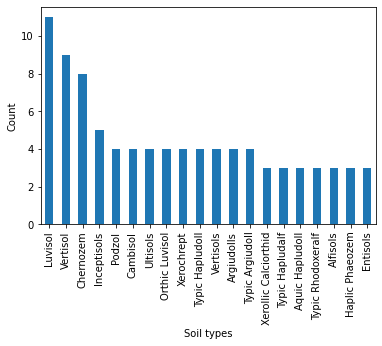

In [11]:
# graph
ie = dfssp['soil_type_nlp'].notnull()
soiltypes = np.hstack([a.split('|') for a in dfssp[ie]['soil_type_nlp']])
s = pd.Series(soiltypes)
s.value_counts()[:20].plot.bar(ylabel='Count', xlabel='Soil types');

In [12]:
def mode(x):
    return stats.mode(x).mode[0]
dfmode = dfssp.groupby('ReferenceTag').agg(mode)
dfmode['soil_type_status'].value_counts()

matched        94
unavailable    72
parsed          8
Name: soil_type_status, dtype: int64

In [13]:
# scores on the selection of relevant information
df = dfmode['soil_type_status'].value_counts()
n = df.sum()
if 'not matched' not in df.index:
    df['not matched'] = 0
df['relevant'] = df['matched'] + df['not matched']
tp = df['relevant']
fp = df['parsed'] if 'parsed' in df.index else 0
tn = df['unavailable'] if 'unavailable' in df.index else 0
fn = df['not parsed'] if 'not parsed' in df.index else 0

recall = tp/(tp + fn)
precision = tp/(tp + fp)
f1 = 2 * (precision * recall)/(precision + recall)
match = (df['matched'] + df['unavailable'])/(tp+tn+fn+fp)
print('recall: {:.2f}'.format(recall))
print('precision: {:.2f}'.format(precision))
print('F1 score: {:.2f}'.format(f1))
print('match: {:.2f}'.format(match))
dfscore = dfscore.append(
    {'step': 'Soil type (WRB/USDA)',
     'n': n,
     'recall': recall,
     'precision': precision,
     'f1': f1,
     'match': match,
     'method': 'Regex + dict.',
    }, ignore_index=True)
dfscore

recall: 1.00
precision: 0.92
F1 score: 0.96
match: 0.95


,step,recall,f1,match,n,precision,method
0,Soil type (WRB/USDA),1.0,0.959184,0.954023,174,0.921569,Regex + dict.


Very high precision due to the specific lexic of soil types. False positive occurs when soil types is mention in the main text but is not related to the field site.

### Extract soil texture

In [14]:
# soil texture
# note the vocs needs to be from the longest one to the shortest one as the
# regex re.findall() will stop at the first match found
voc = [
    'sandy clay loam', 'silty clay loam',
    'loamy sand', 'sandy loam', 'clay loam', 'sandy clay',
    'silty clay', 'silt loam',
    'sand', 'silt', 'clay', 'loam'
]
#text = "the experiment took place on a silty clay loam and a clay loam"
#print(re.findall('|'.join(voc), text.lower()))

In [15]:
# extract soil textures
dfssp['soil_texture_status'] = 'unavailable'
dfssp.loc[dfssp['soil_texture'].notnull(), 'soil_texture_status'] = 'not parsed'  # available in db but not parsed
dfssp['soil_texture_nlp'] = pd.NA
for i, doc in tqdm(enumerate(rawdocs), total=len(rawdocs)):
    # spacy phrase matcher is a bit slower than re module
    # re.findall() will stop at the first match, as we've ordered the voc
    # from the longest to the smallest, we avoid matching twice 'sandy clay loam'
    # for 'clay loam' or 'clay' or 'loam' but only for 'sandy clay loam'
    text = doc.lower()
    # remove sand occurence usually applied for better contact with permeameter
    text = re.sub('(fine\s+sand|moist\s+\sand|contact\ssand|sand\s+pad|washed\s+sand|(sand|clay|silt)\s+content)', '', text)
    if len(re.findall('fine\s+sand', text)) > 0:
        print('+++++++++++++++', re.findall('fine\s+sand', text))
    matches = re.findall('|'.join(voc), text)  # maybe case would help here actually
    umatches = np.unique(matches)
    ie = dfssp['ReferenceTag'] == dfpub.loc[i, 'ReferenceTag']
    # check against manually inputed values
    for j in np.where(ie)[0]:  # index in dfssp
        if len(umatches) > 0:
            dfssp.loc[ie, 'soil_texture_nlp'] = '|'.join(umatches)
            if dfssp.loc[j, 'soil_texture_status'] == 'unavailable':
                dfssp.loc[j, 'soil_texture_status'] = 'parsed'
            elif dfssp.loc[j, 'soil_texture_status'] == 'not parsed':
                dfssp.loc[j, 'soil_texture_status'] = 'not matched'
            if pd.isna(dfssp.loc[j, 'soil_texture']) == False:
                for umatch in umatches:
                    if umatch in dfssp.loc[j, 'soil_texture']:
                        dfssp.loc[j, 'soil_texture_status'] = 'matched'
                        break

        # selective print for debugging
        if dfssp.loc[j, 'soil_texture_status'] in []:#'not matched', 'parsed', 'not parsed']:
            print(dfssp.loc[j, 'soil_texture_status'], '> label:', dfssp.loc[j, 'soil_texture'], '| nlp:', umatches,
                  '<<', dfpub.loc[i, 'fname'], '>>', dfssp.loc[j, 'SSPName'], i, j)

# bodner2013 : coming from abstract and references
# carey2007: fine layer of moist sand applied
# cey2009 should match, it's a silt loam
# contact sand, sand content, clay content

  0%|          | 0/154 [00:00<?, ?it/s]

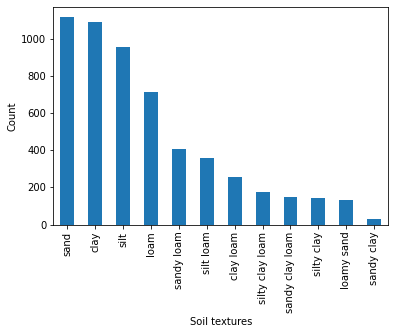

In [16]:
# graph
ie = dfssp['soil_texture_nlp'].notnull()
items = np.hstack([a.split('|') for a in dfssp[ie]['soil_texture_nlp']])
s = pd.Series(items)
s.value_counts()[:20].plot.bar(ylabel='Count', xlabel='Soil textures');

In [17]:
# group per publication to have meaningfull stats
def mode(x):
    return stats.mode(x).mode[0]
dfmode = dfssp.groupby('ReferenceTag').agg(mode)
dfmode['soil_texture_status'].value_counts()

matched        143
not parsed      20
parsed           8
unavailable      2
not matched      1
Name: soil_texture_status, dtype: int64

In [18]:
# scores on the selection of relevant information
df = dfmode['soil_texture_status'].value_counts()
if 'not matched' not in df.index:
    df['not matched'] = 0
n = df.sum()
df['relevant'] = df['matched'] + df['not matched']
tp = df['relevant']
fp = df['parsed'] if 'parsed' in df.index else 0
tn = df['unavailable'] if 'unavailable' in df.index else 0
fn = df['not parsed'] if 'not parsed' in df.index else 0

recall = tp/(tp + fn)
precision = tp/(tp + fp)
f1 = 2 * (precision * recall)/(precision + recall)
match = (df['matched'] + df['unavailable'])/(tp+tn+fn+fp)
print('recall: {:.2f}'.format(recall))
print('precision: {:.2f}'.format(precision))
print('F1 score: {:.2f}'.format(f1))
print('match: {:.2f}'.format(match))
dfscore = dfscore.append(
    {'step': 'Soil texture (USDA)',
     'n': n,
     'recall': recall,
     'precision': precision,
     'f1': f1,
     'match': match,
     'method': 'Regex + dict.'},
    ignore_index=True)
dfscore

recall: 0.88
precision: 0.95
F1 score: 0.91
match: 0.83


,step,recall,f1,match,n,precision,method
0,Soil type (WRB/USDA),1.000000,0.959184,0.954023,174,0.921569,Regex + dict.
1,Soil texture (USDA),0.878049,0.911392,0.833333,174,0.947368,Regex + dict.


### Extract rainfall

In [19]:
# extract mean annual rainfall
dfloc['rainfall_status'] = 'unavailable'
dfloc.loc[dfloc['rainfall'].notnull(), 'rainfall_status'] = 'not parsed'  # available in db but not parsed
dfloc['rainfall_nlp'] = pd.NA
for i, doc in tqdm(enumerate(rawdocs), total=len(rawdocs)):
    text = doc.replace('\n',' ').lower()
    text = re.sub('\([a-z\s]+\., \d{4}\)', '', text)  # remove citation in parenthesis 
    text = text = re.sub('[^0-9a-z.,\s\-–]', '', text)  # remove other characters
    matches = re.findall('((?:cumulated|annual|average)[a-z\s]+(?:rainfall|rain|precipitation))(?:[a-z\s]+)?(\d+[.-\–]?\d+c)?[a-z\s]+(\d+\.?,?\d+(?:-|–|\sand\s|\sto\s)?(?:\d+)?)\s?(m\s?m|cm)', text)
    umatches = []
    for a in matches:
        if a[-1] == 'mm':
            s = a[-2]
        elif a[-1] == 'cm':
            s = '{:.0f}'.format(float(a[-2])*10)
        if ('-' in s) or ('–' in s) or ('to' in s):
            s = '{:.0f}'.format(np.mean([float(a) for a in re.split('-|–|to', s)]))
        s = s.replace(',', '')
        if 'and' in s:
            umatches.append(s.split(' and ')[0])
            umatches.append(s.split(' and ')[1])
        else:
            umatches.append(s)
    ie = dfloc['ReferenceTag'] == dfpub.loc[i, 'ReferenceTag']
    # check against manually inputed values
    for j in np.where(ie)[0]:  # index in dfloc
        if len(umatches) > 0:
            dfloc.loc[ie, 'rainfall_nlp'] = '|'.join(umatches)
            if dfloc.loc[j, 'rainfall_status'] == 'unavailable':
                dfloc.loc[j, 'rainfall_status'] = 'parsed'
            elif dfloc.loc[j, 'rainfall_status'] == 'not parsed':
                dfloc.loc[j, 'rainfall_status'] = 'not matched'
            if pd.isna(dfloc.loc[j, 'rainfall']) == False:
                if dfloc.loc[j, 'rainfall'] in [float(u) for u in umatches]:
                    dfloc.loc[j, 'rainfall_status'] = 'matched'

        # selective print for debugging
        if dfloc.loc[j, 'rainfall_status'] in []:#'not matched', 'parsed', 'not parsed']:
            print(dfloc.loc[j, 'rainfall_status'], '> label:', dfloc.loc[j, 'rainfall'], '| nlp:', umatches,
                  '<<', dfpub.loc[i, 'fname'], '>>', dfloc.loc[j, 'Location'], i, j)
# comments
# beibei2016: one line out of two is intercalted because of bad conversion of pdf2txt
# miller2008: provide per year average, use of pronouns for the long-term average
# swcharzel2011: not full text provided only abstract or so
# zeng2013b: range with each with unit 234 mm to 240 mm

  0%|          | 0/154 [00:00<?, ?it/s]

In [20]:
# group per publication to have meaningfull stats
def mode(x):
    return stats.mode(x).mode[0]
dfmode = dfloc.groupby('ReferenceTag').agg(mode)
dfmode['rainfall_status'].value_counts()

unavailable    94
matched        60
not parsed     15
not matched     5
Name: rainfall_status, dtype: int64

In [21]:
# scores on the selection of relevant information
df = dfmode['rainfall_status'].value_counts()
n = df.sum()
df['relevant'] = df['matched'] + df['not matched']
tp = df['relevant']
fp = df['parsed'] if 'parsed' in df.index else 0
tn = df['unavailable'] if 'unavailable' in df.index else 0
fn = df['not parsed'] if 'not parsed' in df.index else 0

recall = tp/(tp + fn)
precision = tp/(tp + fp)
f1 = 2 * (precision * recall)/(precision + recall)
match = (df['matched'] + df['unavailable'])/(tp+tn+fn+fp)
print('recall: {:.2f}'.format(recall))
print('precision: {:.2f}'.format(precision))
print('F1 score: {:.2f}'.format(f1))
print('match: {:.2f}'.format(match))
dfscore = dfscore.append(
    {'step': 'Rainfall',
     'n': n,
     'recall': recall,
     'precision': precision,
     'f1': f1,
     'match': match,
     'method': 'Regex'},
    ignore_index=True)
dfscore

recall: 0.81
precision: 1.00
F1 score: 0.90
match: 0.89


,step,recall,f1,match,n,precision,method
0,Soil type (WRB/USDA),1.000000,0.959184,0.954023,174,0.921569,Regex + dict.
1,Soil texture (USDA),0.878049,0.911392,0.833333,174,0.947368,Regex + dict.
2,Rainfall,0.812500,0.896552,0.885057,174,1.000000,Regex


### Extract altitude

In [22]:
# extract altitude/elevation (but we don't have labelled values)
for i, text in tqdm(enumerate(rawdocs), total=len(rawdocs)):
    match1 = re.findall('((\d+)\s?m[a-z\s]+(altitude|elevation))', text.replace('\n',' ').lower())
    match2 = re.findall('((altitude|elevation)[a-z\s]+(\d+)\s?m)', text.replace('\n',' ').lower())
    match = match1 + match2
    doc = text.replace('\n', ' ').lower()
    matchd = [doc[m.start()-20:m.end()+20] for m in re.finditer('(altitude|elevation)', doc)]
    #print(dfpub.loc[i, 'fname'], matchd, match)

  0%|          | 0/154 [00:00<?, ?it/s]

### Extract disk diameter

In [23]:
# extract disk radius
dfmtf['diameter_status'] = 'unavailable'
dfmtf.loc[dfmtf['diameter'].notnull(), 'diameter_status'] = 'not parsed'  # available in db but not parsed
dfmtf['diameter_nlp'] = pd.NA
for i, doc in tqdm(enumerate(rawdocs), total=len(rawdocs)):
    text = doc.replace('\n',' ').lower()
    match1 = re.findall('(radius|diameter)[a-z\s]+(\d+\.?\d+)\s?(cm|mm)', text)
    match2 = re.findall('(\d+\.?\d+)\s?(cm|mm)[a-z\s]+(radius|diameter)', text)
    match = match1 + match2
    umatches = []
    for a in match1:
        val = float(a[1])
        val = val/10 if a[2] == 'mm' else val
        val = val * 2 if a[0] == 'radius' else val
        umatches.append(val)
    for a in match2:
        val = float(a[0])
        val = val/10 if a[1] == 'mm' else val
        val = val * 2 if a[2] == 'radius' else val
        umatches.append(val)
    if len(umatches) > 0:
        # check against manually inputed values
        ie = dfmtf['ReferenceTag'] == dfpub.loc[i, 'ReferenceTag']
        dfmtf.loc[ie, 'diameter_nlp'] = '|'.join([str(a) for a in umatches])
        for j in np.where(ie)[0]:  # index in dfmtf
            if dfmtf.loc[j, 'diameter_status'] == 'unavailable':
                dfmtf.loc[j, 'diameter_status'] = 'parsed'
            elif dfmtf.loc[j, 'diameter_status'] == 'not parsed':
                dfmtf.loc[j, 'diameter_status'] = 'not matched'
            if pd.isna(dfmtf.loc[j, 'diameter']) == False:
                if dfmtf.loc[j, 'diameter'] in umatches:
                    dfmtf.loc[j, 'diameter_status'] = 'matched'

            # selective print for debugging
            if dfmtf.loc[j, 'diameter_status'] in []:#'not matched', 'parsed']:
                print(dfmtf.loc[j, 'diameter_status'], i, '--', j, '++++', dfmtf.loc[j, 'diameter'], umatches,
                      '<<', dfpub.loc[i, 'fname'])
    else:
        if False:  # set to True for debuggin
            for j in np.where(ie)[0]:
                # if the db says that we have something but the nlp hasn't detected it
                if pd.isna(dfmtf.loc[j, 'diameter']) == False:
                    print('not parsed', '> label:', dfmtf.loc[j, 'diameter'], '| nlp: []',
                          '<<', dfpub.loc[i, 'fname'], '>>', dfmtf.loc[j, 'MTFName'])

# comments


  0%|          | 0/154 [00:00<?, ?it/s]

In [24]:
# group per publication to have meaningfull stats
def mode(x):
    return stats.mode(x).mode[0]
dfmode = dfmtf.groupby('ReferenceTag').agg(mode)
dfmode['diameter_status'].value_counts()

matched        59
not parsed     49
not matched    35
parsed         19
unavailable    12
Name: diameter_status, dtype: int64

In [25]:
# scores on the selection of relevant information
df = dfmode['diameter_status'].value_counts()
n = df.sum()
df['relevant'] = df['matched'] + df['not matched']
tp = df['relevant']
fp = df['parsed'] if 'parsed' in df.index else 0
tn = df['unavailable'] if 'unavailable' in df.index else 0
fn = df['not parsed'] if 'not parsed' in df.index else 0

recall = tp/(tp + fn)
precision = tp/(tp + fp)
f1 = 2 * (precision * recall)/(precision + recall)
match = (df['matched'] + df['unavailable'])/(tp+tn+fn+fp)
print('recall: {:.2f}'.format(recall))
print('precision: {:.2f}'.format(precision))
print('F1 score: {:.2f}'.format(f1))
print('match: {:.2f}'.format(match))
dfscore = dfscore.append(
    {'step': 'Disk diameter',
     'n': n,
     'recall': recall,
     'precision': precision,
     'f1': f1,
     'match': match,
     'method': 'Regex'},
    ignore_index=True)
dfscore

recall: 0.66
precision: 0.83
F1 score: 0.73
match: 0.41


,step,recall,f1,match,n,precision,method
0,Soil type (WRB/USDA),1.000000,0.959184,0.954023,174,0.921569,Regex + dict.
1,Soil texture (USDA),0.878049,0.911392,0.833333,174,0.947368,Regex + dict.
2,Rainfall,0.812500,0.896552,0.885057,174,1.000000,Regex
3,Disk diameter,0.657343,0.734375,0.408046,174,0.831858,Regex


### Extract tensions

Issue: most tensions are only given in the graphs or in tables (so hard to parse). Few are given in the text and we would need manual labelling to obtain a score.

In [26]:
# extract tensions used
dfm = dfpub.merge(dfexp).merge(dfmtf)
dfm['Tmin_nlp'] = np.nan
dfm['Tmax_nlp'] = np.nan
dfm['Tmin_status'] = 'not available'
dfm['Tmax_status'] = 'not available'
dfm.loc[dfm['Tmin'].notnull(), 'Tmin_status'] = 'not parsed'
dfm.loc[dfm['Tmax'].notnull(), 'Tmax_status'] = 'not parsed'
# number of references with different Tmin/Tmax (std is not 0)
print(dfm.groupby('ReferenceTag').std()['Tmax'].abs().gt(0).sum(), 'refs with multiple Tmin/Tmax')

for i, doc in tqdm(enumerate(rawdocs), total=len(rawdocs)):
    text = doc.replace('\n', ' ').lower()
    #matches = re.findall('(\-?\s?\d{1,3},\s)+\s+and\s+(\-?\s?\d{1,3}\s(mm|cm))', text)
    text = text.replace(' and ', ', ')
    matches = re.findall('((?:(?:-?\d+),?\s){2,})\s?(mm|cm|kPa)', text)
    tmin, tmax = np.nan, np.nan
    if len(matches) > 0:
        if ',' in matches[0][0]:
            tt = np.abs([float(a.strip()) for a in matches[0][0].split(',')])
            if matches[0][-1] == 'cm':
                tt = [10*t for t in tt]
            elif matches[0][-1] == 'kPa':
                tt = [101.97162129779*t for t in tt]
            tmin = np.min(tt)
            tmax = np.max(tt)
    iref = dfm['ReferenceTag'].eq(dfpub.loc[i, 'ReferenceTag'])
    tensions = dfm[iref][['Tmin', 'Tmax']].values[0, :]
    if pd.isna(tmin) is False:
        if tmin == tensions[0]:
            dfm.loc[iref, 'Tmin_status'] = 'matched'
        else:
            dfm.loc[iref, 'Tmin_status'] = 'not matched'
    if pd.isna(tmax) is False:
        if tmax == tensions[1]:
            dfm.loc[iref, 'Tmax_status'] = 'matched'
        else:
            dfm.loc[iref, 'Tmax_status'] = 'not matched'
    #print(dfpub.loc[i, 'fname'], tensions, ' | nlp:', [tmin, tmax], matches)

# comments


9 refs with multiple Tmin/Tmax


  0%|          | 0/154 [00:00<?, ?it/s]

In [27]:
# for how many have we got both Tmin and Tmax matched
df = dfm.groupby('ReferenceTag').first()
n = (df['Tmin_status'].eq('matched') & df['Tmax_status'].eq('matched')).sum()
print(n, 'references have both Tmin and Tmax matched')

14 references have both Tmin and Tmax matched


In [28]:
# group per publication to have meaningfull stats
def mode(x):
    return stats.mode(x).mode[0]
dfmode = dfm.groupby('ReferenceTag').agg(mode)
dfmode['diameter_status'].value_counts()

matched        59
not matched    35
not parsed     32
parsed         19
unavailable     9
Name: diameter_status, dtype: int64

In [29]:
# scores on the selection of relevant information
df = dfmode['Tmax_status'].value_counts()
n = df.sum()
df['relevant'] = df['matched'] + df['not matched']
tp = df['relevant']
fp = df['parsed'] if 'parsed' in df.index else 0
tn = df['unavailable'] if 'unavailable' in df.index else 0
fn = df['not parsed'] if 'not parsed' in df.index else 0

recall = tp/(tp + fn)
precision = tp/(tp + fp)
f1 = 2 * (precision * recall)/(precision + recall)
match = df['matched']/df['relevant']
print('recall: {:.2f}'.format(recall))
print('precision: {:.2f}'.format(precision))
print('F1 score: {:.2f}'.format(f1))
print('match: {:.2f}'.format(match))
dfscore = dfscore.append(
    {'step': 'Tensions (Tmax)',
     'n': n,  # note that not all references have data in dfmtf
     'recall': recall,
     'precision': precision,
     'f1': f1,
     'match': match, 
     'method': 'Regex'},
    ignore_index=True)
dfscore

recall: 0.56
precision: 1.00
F1 score: 0.72
match: 0.31


,step,recall,f1,match,n,precision,method
0,Soil type (WRB/USDA),1.000000,0.959184,0.954023,174,0.921569,Regex + dict.
1,Soil texture (USDA),0.878049,0.911392,0.833333,174,0.947368,Regex + dict.
2,Rainfall,0.812500,0.896552,0.885057,174,1.000000,Regex
3,Disk diameter,0.657343,0.734375,0.408046,174,0.831858,Regex
4,Tensions (Tmax),0.564935,0.721992,0.310345,154,1.000000,Regex


### Extract GPS coordinates

In [30]:
# convert to decimal degree
def dms2dec(out):
    # string, deg, symbol, minute, symbol, second, symbol, direction
    deg = float(out[1]) if out[1] != '' else 0
    mnt = float(out[3]) if out[3] != '' else 0
    sec = float(out[5]) if out[5] != '' else 0
    dec = deg + mnt/60 + sec/60/60
    dec = -dec if (out[-1] == 'S')|(out[-1] == 'W')|(out[-1] == 'O') else dec
    return dec

In [31]:
# detect GPS coordinates
coord = []
dfloc['location_status'] = 'unavailable'  # not in db
dfloc.loc[dfloc['lat'].notnull(), 'location_status'] = 'not parsed'  # available in db but not parsed
for i, text in tqdm(enumerate(rawdocs), total=len(rawdocs)):
    # try to match DMS notation
    text = text.replace('\n',' ').replace('\x04','*').replace('\x03','*')
    text = text.replace('\x01','*').replace(',','.') # \x04 is EOT End Of Transmission
    latTime = re.findall("(([+-]?[1-8]?\d|[+-]?90)([°◦*oO])\s?(\d{1,2})(.)\s?(\d{1,2}(\.\d+)?)?.?.?\s?(latitude\s)?([NS]))", text)
    lonTime = re.findall("(([+-]?180|[+-]?1[0-7]\d|[+-]?[1-9]?\d)([°◦*oO])\s?(\d{1,2}?)(.)\s?(\d{1,2}(\.\d+)?)?.?.?\s?(longitude\s)?([WEO]))", text)

    # sometimes the symbol for minutes is transformed in a zero
    if len(latTime) > 0:
        for l in range(len(latTime)):
            a = latTime[l]
            if a[3] == ' ':  # we would expect the symbol for minute
                latTime[l] = a[:2] + (latTime[l][2][:-1],) + a[3:]  # remove last symbol
    if len(lonTime) > 0:
        for l in range(len(lonTime)):
            a = lonTime[l]
            if a[3] == ' ':  # we would expect the symbol for minute
                lonTime[l] = a[:2] + (lonTime[l][2][:-1],) + a[3:]  # remove last symbol

    # try some popular edge cases
    if len(latTime) == 0:
        latTime = re.findall("((\d+)(8)(\d{2,}))(['0V9])\s?(\d+\.\d+)?()\s?(latitude\s)?([NS])", text)
        lonTime = re.findall("((\d+)(8)(\d{2,}))(['0V9])\s?(\d+\.\d+)?()\s?(longitude\s)?([WOE])", text)
        
    if len(latTime) == 0:
        latTime = re.findall("(([NS])\s(\d+)(8)(\d{2,}))(['0V9])\s?(\d+\.\d+)?()", text)
        lonTime = re.findall("(([WOE])\s(\d+)(8)(\d{2,}))(['0V9])\s?(\d+\.\d+)?()", text)
        latTime = [a[1:] + (a[-1],) for a in latTime]
        lonTime = [a[1:] + (a[-1],) for a in lonTime]

    # convert to decimal degree
    lats = [dms2dec(a) for a in latTime]
    lons = [dms2dec(a) for a in lonTime]

    # try to match decimal notation
    if len(lats) == 0:
        latDeg = re.findall("([+-]?(([1-8]?\d|90)\.\d+)[°◦*oO⬚]?\s?([NS]))", text)
        lonDeg = re.findall("([-+]?((180|1[0-7]\d|[1-9]?\d)\.\d+)[°◦*oO⬚]?\s?([WEO]))", text)
        lats = [float(a[1]) if a[3] == 'N' else -float(a[1]) for a in latDeg]
        lons = [float(a[1]) if a[3] == 'E' else -float(a[1]) for a in lonDeg]

    # edge case of decimal notation
    if len(lats) == 0:
        latDeg = re.findall("(lat\.\s.(([+-]?[1-8]?\d|[+-]?90)\.\d+)[°◦*oO⬚]?)", text)
        lonDeg = re.findall("(long\.\s.(([-+]?180|[-+]?1[0-7]\d|[-+]?[1-9]?\d)\.\d+)[°◦*oO⬚]?)", text)
        lats = [float(a[1]) for a in latDeg]
        lons = [float(a[1]) for a in lonDeg]
        
    # rounding for easier comparison
    lats = [np.round(a, 2) for a in lats]
    lons = [np.round(a, 2) for a in lons]
    
    # save them
    dfloc.loc[i, 'location_nlp'] = ','.join([str(a) for a in lats]) + '|' + \
                                   ','.join([str(a) for a in lons])
    if len(latTime) > 0:
        dfloc.loc[i, 'location_status'] = 'found'
    
    # check against manually inputed values
    ie = dfloc['ReferenceTag'] == dfpub.loc[i, 'ReferenceTag']
    for j in np.where(ie)[0]:  # index in dfloc
        if len(lats) > 0:
            if dfloc.loc[j, 'location_status'] == 'unavailable':
                dfloc.loc[j, 'location_status'] = 'parsed'
            elif dfloc.loc[j, 'location_status'] == 'not parsed':
                dfloc.loc[j, 'location_status'] = 'not matched'
            if np.nanmin(np.array(lats) - dfloc.loc[j, 'lat']) < 0.1:  # some tolerance
                dfloc.loc[j, 'location_status'] = 'matched'
        if dfloc.loc[j, 'location_status'] in []:#'parsed']:
            print(dfloc.loc[j, 'location_status'], i, '--', j, '++++', dfloc.loc[j, 'lat'], lats,
                  '||', latTime, latDeg, '<<', dfpub.loc[i, 'fname'])

    #print(i, latTime, lonTime)
    if len(latTime) > 0:
        coord += latTime

  0%|          | 0/154 [00:00<?, ?it/s]

In [32]:
dfloc['location_status'].value_counts()/dfloc.shape[0]*100

matched        33.971292
found          22.009569
not parsed     13.875598
unavailable    13.875598
not matched    12.440191
parsed          3.827751
Name: location_status, dtype: float64

In [33]:
# scores on the selection of relevant information
df = dfloc['location_status'].value_counts()
n = df.sum()
df['relevant'] = df['matched'] + df['not matched']
tp = df['relevant']
fp = df['parsed'] if 'parsed' in df.index else 0
tn = df['unavailable'] if 'unavailable' in df.index else 0
fn = df['not parsed']

recall = tp/(tp + fn)
precision = tp/(tp + fp)
f1 = 2 * (precision * recall)/(precision + recall)
match = df['matched']/df['relevant']
print('recall: {:.2f}'.format(recall))
print('precision: {:.2f}'.format(precision))
print('F1 score: {:.2f}'.format(f1))
print('match: {:.2f}'.format(match))
dfscore = dfscore.append(
    {'step': 'Coordinates',
     'n': n,
     'recall': recall,
     'precision': precision,
     'f1': f1,
     'match': match,
     'method': 'Regex',
    }, ignore_index=True)
dfscore.tail()

recall: 0.77
precision: 0.92
F1 score: 0.84
match: 0.73


,step,recall,f1,match,n,precision,method
1,Soil texture (USDA),0.878049,0.911392,0.833333,174,0.947368,Regex + dict.
2,Rainfall,0.812500,0.896552,0.885057,174,1.000000,Regex
3,Disk diameter,0.657343,0.734375,0.408046,174,0.831858,Regex
4,Tensions (Tmax),0.564935,0.721992,0.310345,154,1.000000,Regex
5,Coordinates,0.769841,0.839827,0.731959,209,0.923810,Regex


In [34]:
# table for paper
pd.set_option('display.precision', 2)
df = dfscore.copy().rename(columns={'step': 'Extracted', 'recall': 'Recall', 'method': 'Method',
                                    'precision': 'Precision', 'match': 'Accuracy', 'f1': 'F1-score'})

df[['Extracted', 'Method', 'n', 'Precision', 'Recall', 'F1-score', 'Accuracy']].style.hide_index()

Extracted,Method,n,Precision,Recall,F1-score,Accuracy
Soil type (WRB/USDA),Regex + dict.,174,0.92,1.00,0.96,0.95
Soil texture (USDA),Regex + dict.,174,0.95,0.88,0.91,0.83
Rainfall,Regex,174,1.00,0.81,0.90,0.89
Disk diameter,Regex,174,0.83,0.66,0.73,0.41
Tensions (Tmax),Regex,154,1.00,0.56,0.72,0.31
Coordinates,Regex,209,0.92,0.77,0.84,0.73


## Extract management practices
Just use keywords and possibly lemna frequency to identify which practice is being used. The keywords for the agricultural practices come from the [Bonares knowledge library](https://klibrary.bonares.de) and are completemented by AGROVOC vocabulary.

In [35]:
# load vocabulary
dfsyn = pd.read_csv(datadir + '../dfsyn.csv')  # load original words and their synonyms
dfsyn.head()

,word,bonares_voc,lemma
0,fertilization,fertilization,fertilization
1,balanced fertilization,fertilization,balanced fertilization
2,broadcast fertilization,fertilization,broadcast fertilization
3,foliar fertilization,fertilization,foliar fertilization
4,in vitro fertilization,fertilization,in vitro fertilization


In [36]:
# regex-based (fast enough)
lemmas = dfsyn['lemma'].unique()
dfmgtcoo = pd.DataFrame(columns=['pubid', 'ReferenceTag'] + list(lemmas))
for i, doc in tqdm(enumerate(rawdocs), total=len(rawdocs)):
    dfmgtcoo.loc[i, 'pubid'] = dfpub.loc[i, 'fname']
    dfmgtcoo.loc[i, 'ReferenceTag'] = dfpub.loc[i, 'ReferenceTag']
    for lemma in lemmas:
        matches = re.findall(lemma, doc.lower())
        dfmgtcoo.loc[i, lemma] = len(matches)
dfmgtcoo.to_csv(datadir + 'dfmgtcoo.csv', index=False)

  0%|          | 0/154 [00:00<?, ?it/s]

In [37]:
# load
dfmgtcoo = pd.read_csv(datadir + 'dfmgtcoo.csv')

21 number of lemma found at least once in a document


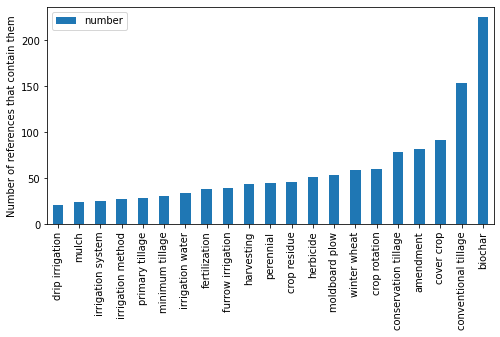

In [38]:
# overview
s = pd.DataFrame(dfmgtcoo.sum())
s = s[2:]  # remove first pubid an referencetag
s = s.drop_duplicates()
s = s.rename(columns={s.columns[0]: 'number'})
s = s[s['number'] > 20]  # discard too small
s = s[s['number'] < 500] # discard too big
s = s[~s.index.isin(['drainage', 'sow', 'space','residue'])]
s = s.sort_values('number')
print(s.shape[0], 'number of lemma found at least once in a document')
fig, ax = plt.subplots(figsize=(8, 4))
s.plot.bar(ylabel='Number of references that contain them', ax=ax);

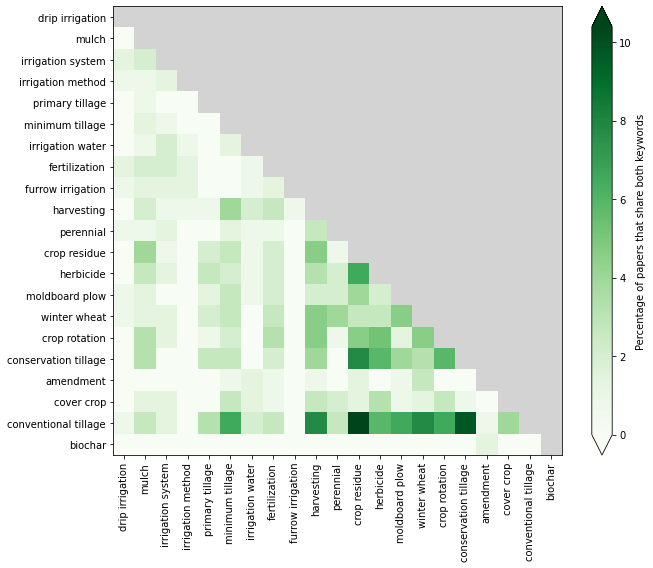

In [39]:
# simple co-occurence matrix between concept
# which practice is usually investigated with which other
# a practice is 'investigated' if keywords appears more than 10 times
cols = s.index
n = len(cols)
coo = np.zeros((n, n))*np.nan
cooPrc = np.zeros(coo.shape)*np.nan
df = dfmgtcoo[cols].copy().reset_index(drop=True) > 0  # the document contains the word
for i, col in enumerate(cols):
    serie = df[col]
    x = df.values & serie.values[:, None]  # number of studies that shares the keywords
    coo[i, :] = np.sum(x, axis=0)
    cooPrc[i, :i] = np.sum(x, axis=0)[:i]/df.shape[0]*100
fig, ax = plt.subplots(figsize=(10, 8))
cmap = plt.get_cmap('Greens')
cmap.set_bad('lightgrey')
cax = ax.imshow(cooPrc, cmap=cmap)
fig.colorbar(cax, ax=ax, label='Percentage of papers that share both keywords', extend='both')
labs = []
for col in cols:
    word = dfsyn[dfsyn['lemma'] == col]['bonares_voc'].values[0]
    labs.append('{:s}'.format(col))
labs = cols
xx = np.arange(n)
ax.set_xticks(xx)
ax.set_xticklabels(labs, rotation=90)
ax.set_yticks(xx)
ax.set_yticklabels(labs)
fig.tight_layout()
fig.savefig(outputdir + 'co-occurrence-practices-otim.jpg', dpi=300)